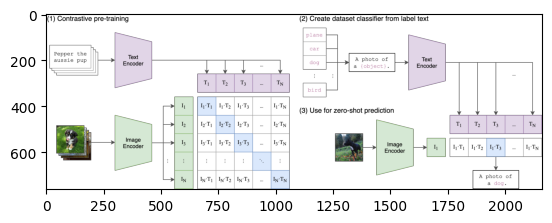

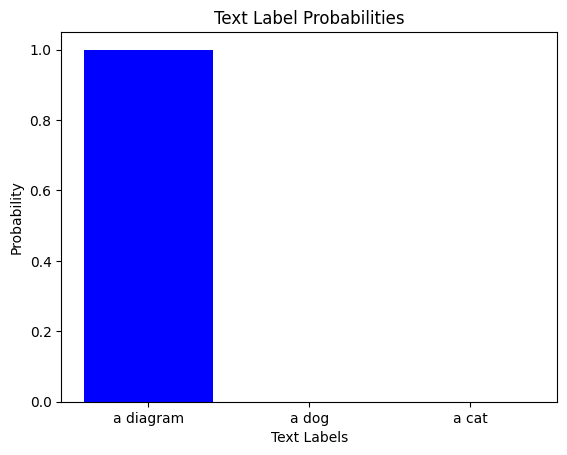

In [9]:
import torch
from PIL import Image
import open_clip
import matplotlib.pyplot as plt

# 加载预训练的 ViT-B-32 模型，并使用 laion2b_s34b_b79k 预训练权重
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

# 将模型设置为评估模式，避免 BatchNorm 和 Dropout 等层的影响
model.eval()

# 获取与模型对应的 tokenizer
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# 加载图像并进行预处理
raw_image = Image.open("CLIP.png")
# 我们展示这张图片
plt.imshow(raw_image)
plt.show()

# 这张图就是一个图表diagram，我们期望这个模型将其认出来为diagram
image = preprocess(raw_image).unsqueeze(0)

# 对文本进行 tokenize，这些是候选选项
text = tokenizer(["a diagram", "a dog", "a cat"])

# 使用 torch.no_grad() 和 torch.cuda.amp.autocast() 进行推理
# torch.no_grad() 可以减少内存使用并加速推理
# torch.cuda.amp.autocast() 可以加速混合精度计算
with torch.no_grad(), torch.cuda.amp.autocast():
    # 提取图像特征
    image_features = model.encode_image(image)
    
    # 提取文本特征
    text_features = model.encode_text(text)
    
    # 对特征进行归一化
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # 计算图像特征和文本特征的相似度，并进行 softmax 归一化
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# 提取概率值
probs = text_probs.squeeze().cpu().numpy()

# 创建柱状图
labels = ["a diagram", "a dog", "a cat"]
plt.bar(labels, probs, color=['blue', 'green', 'red'])
plt.xlabel('Text Labels')
plt.ylabel('Probability')
plt.title('Text Label Probabilities')
plt.show()

我们用另一个图片试试看

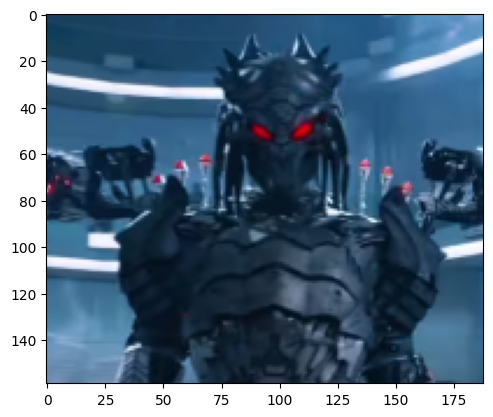

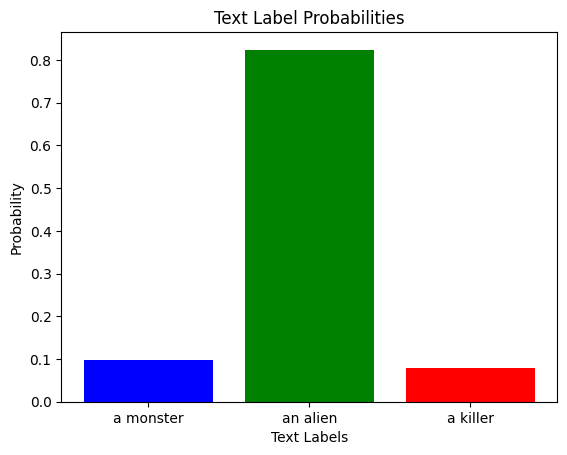

In [12]:
import torch
from PIL import Image
import open_clip
import matplotlib.pyplot as plt

# 加载预训练的 ViT-B-32 模型，并使用 laion2b_s34b_b79k 预训练权重
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

# 将模型设置为评估模式，避免 BatchNorm 和 Dropout 等层的影响
model.eval()

# 获取与模型对应的 tokenizer
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# 加载图像并进行预处理
raw_image = Image.open("image.png")
# 我们展示这张图片
plt.imshow(raw_image)
plt.show()

# 这张图就是一个铁血战士
image = preprocess(raw_image).unsqueeze(0)

# 对文本进行 tokenize，这些是候选选项，他们都比较符合铁血战士的特征，我们看看模型是否会对这些有反应
text = tokenizer(["a monster", "an alien", "a killer"])

# 使用 torch.no_grad() 和 torch.cuda.amp.autocast() 进行推理
# torch.no_grad() 可以减少内存使用并加速推理
# torch.cuda.amp.autocast() 可以加速混合精度计算
with torch.no_grad(), torch.cuda.amp.autocast():
    # 提取图像特征
    image_features = model.encode_image(image)
    
    # 提取文本特征
    text_features = model.encode_text(text)
    
    # 对特征进行归一化
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # 计算图像特征和文本特征的相似度，并进行 softmax 归一化
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# 提取概率值
probs = text_probs.squeeze().cpu().numpy()

# 创建柱状图
labels = ["a monster", "an alien", "a killer"]
plt.bar(labels, probs, color=['blue', 'green', 'red'])
plt.xlabel('Text Labels')
plt.ylabel('Probability')
plt.title('Text Label Probabilities')
plt.show()

我们可以看到，模型确实稍微认同铁血战士是一个monster或者killer，但最认同的还是它是外星人————也确实是。

为了更细致地观察这个模型思考的过程，我们看看image_features /text features

In [15]:
image_features.shape, text_features.shape

(torch.Size([1, 512]), torch.Size([3, 512]))

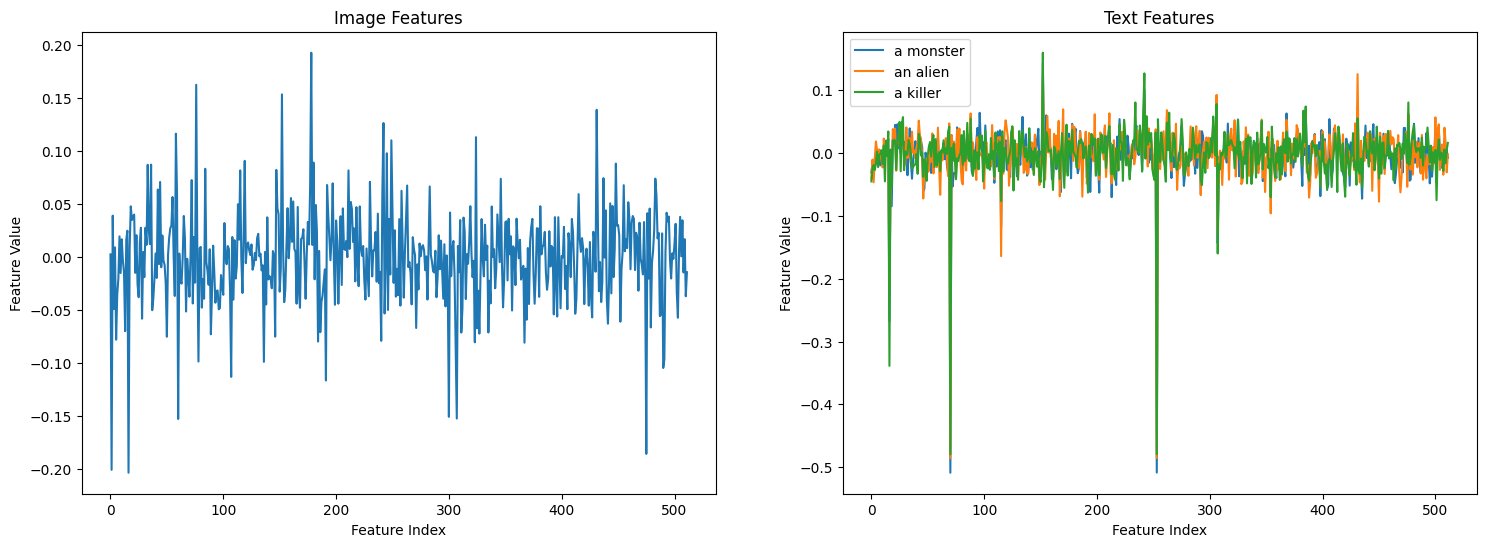

In [18]:
# 可视化图像特征和文本特征
plt.figure(figsize=(18, 6))

# 可视化图像特征
plt.subplot(1, 2, 1)
plt.plot(image_features.squeeze().cpu().numpy())
plt.title('Image Features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')

# 可视化文本特征
plt.subplot(1, 2, 2)
for i, text_feature in enumerate(text_features):
    plt.plot(text_feature.cpu().numpy(), label=labels[i])
plt.title('Text Features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.legend()

plt.show()

`image_features.shape` 和 `text_features.shape` 的输出 `(torch.Size([1, 512]), torch.Size([3, 512]))` 提供了关于图像特征和文本特征的维度信息。

### 图像特征维度

- **`torch.Size([1, 512])`**：
  - `1`：表示 batch size，即图像的数量。在这个例子中，我们只处理了一张图像，所以 batch size 为 1。
  - `512`：表示特征向量的维度。图像特征被编码为一个 512 维的向量。

### 文本特征维度

- **`torch.Size([3, 512])`**：
  - `3`：表示 batch size，即文本的数量。在这个例子中，我们有三个文本标签（"a monster", "an alien", "a killer"），所以 batch size 为 3。
  - `512`：表示特征向量的维度。每个文本标签被编码为一个 512 维的向量。

### 解释

1. **图像特征**：
   - 图像特征是一个 512 维的向量，表示模型从输入图像中提取的特征。这个向量捕捉了图像的语义信息，可以用于与文本特征进行对比。

2. **文本特征**：
   - 每个文本标签（"a monster", "an alien", "a killer"）都被编码为一个 512 维的向量。这些向量捕捉了每个文本标签的语义信息，可以用于与图像特征进行对比。

### 特征对比

- **相似度计算**：
  - 通过计算图像特征和文本特征之间的相似度（例如余弦相似度），模型可以判断图像与哪个文本标签最匹配。
  - 在这个例子中，`text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)` 计算了图像特征与每个文本特征的相似度，并进行了 softmax 归一化，得到每个文本标签的概率。


In [27]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

# 将 image_features 和 text_features 转换为 numpy 数组
image_features_np = image_features.squeeze(0).cpu().numpy()
text_features_np = text_features.cpu().numpy()

# 将两者合并，以便一起进行降维
features_combined = np.vstack([image_features_np, text_features_np])

# 使用 PCA 将 512 维特征降维到 2 维
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_combined)

# 分别提取图像和文本的降维特征
image_features_2d = features_2d[0]  # 图像特征在第一个
text_features_2d = features_2d[1:]  # 文本特征在后面

# 创建一个包含所有点的 DataFrame，用于可视化
data = {
    "x": [image_features_2d[0]] + text_features_2d[:, 0].tolist(),
    "y": [image_features_2d[1]] + text_features_2d[:, 1].tolist(),
    "label": ["Image"] + ["a monster", "an alien", "a killer"],
    "type": ["Image"] + ["Text"] * 3  # 用于区分图像和文本
}

df = pd.DataFrame(data)

# 使用 Plotly 绘制 2D 散点图
fig = px.scatter(df, x="x", y="y", color="type", text="label",
                 title="Image and Text Features in 2D Space",
                 symbol="type")
fig.update_traces(marker=dict(size=8))
fig.show()


看上去在2维空间中alien更接近image

In [29]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(model.encode_image)
attributions = ig.attribute(image, target=0)


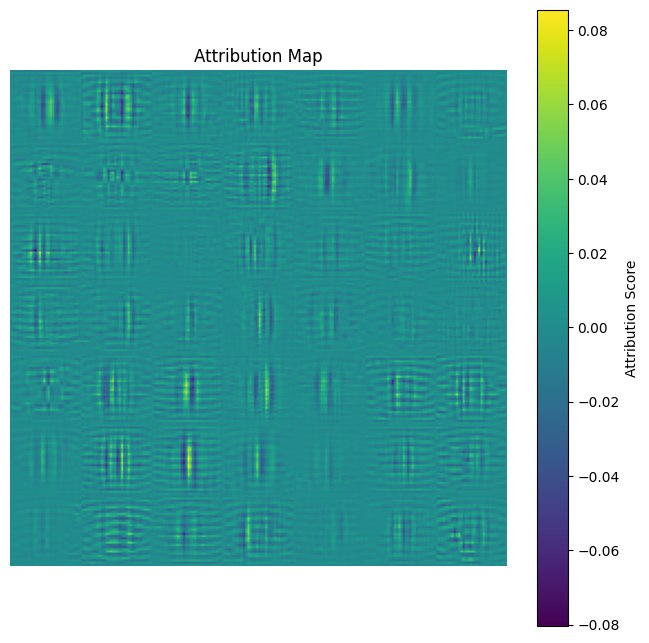

In [35]:
import matplotlib.pyplot as plt
import torch

# 对attributions进行处理：去掉批次维度，并计算通道的平均值以转换为单通道图
attributions = attributions.squeeze(0)  # Shape: [3, 224, 224]

# 归一化到 [0, 1] 区间以便于可视化
attributions_gray = (attributions_gray - attributions_gray.min()) / (attributions_gray.max() - attributions_gray.min())

# 可视化
plt.figure(figsize=(8, 8))
plt.imshow(attributions_gray, cmap='viridis')  # 使用感兴趣的颜色映射，如 'viridis' 或 'hot'
plt.colorbar(label="Attribution Score")
plt.title("Attribution Map")
plt.axis("off")
plt.show()
